In [1]:
# Gerekli kütüphaneler:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
# Data load
csv_file_path = 'loan_approval_dataset_updated.csv'
data_full = pd.read_csv(csv_file_path, encoding='ISO-8859-1', sep=';')

data_full.head()

,loan_id,no_of_dependents,City,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Ankara,Graduate,No,9600000,29900000,12,778.0,2400000.0,17600000,22700000,8000000,Approved
1,2,0,Ankara,NotGraduate,Yes,4100000,12200000,8,417.0,2700000.0,2200000,8800000,3300000,Rejected
2,3,3,Ankara,Graduate,No,9100000,29700000,20,NaN,7100000.0,4500000,33300000,12800000,Rejected
3,4,3,Ankara,Graduate,No,8200000,30700000,8,NaN,18200000.0,3300000,23300000,7900000,Rejected
4,5,5,Ankara,NotGraduate,Yes,9800000,24200000,20,NaN,12400000.0,8200000,29400000,5000000,Rejected


In [3]:
# 'Ýstanbul' ve 'Ýzmir' değerlerini değiştirme
data_full['City'] = data_full['City'].replace({'Ýstanbul': 'istanbul', 'Ýzmir': 'izmir'})

In [4]:
#data summary function:
def check_df(dataframe):
    print("######Shape:######")
    print(dataframe.shape)
    print("######Dtype:######")
    print(dataframe.dtypes)
    print("######Head:######")
    print(dataframe.head())
    print("######Tail:######")
    print(dataframe.tail())
    print("######IsNull:######")
    print(dataframe.isnull().sum())
    print("######Duplicated:######")
    print(dataframe.duplicated().sum())
    print("######Quantile:######")
    print(dataframe.quantile([0,0.05,0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(data_full)

######Shape:######
(4269, 14)
######Dtype:######
loan_id                        int64
 no_of_dependents              int64
City                          object
education                     object
 self_employed                object
 income_annum                  int64
 loan_amount                   int64
 loan_term                     int64
 cibil_score                 float64
 residential_assets_value    float64
 commercial_assets_value       int64
 luxury_assets_value           int64
 bank_asset_value              int64
 loan_status                  object
dtype: object
######Head:######
   loan_id   no_of_dependents    City    education  self_employed   income_annum   loan_amount   loan_term   cibil_score   residential_assets_value   commercial_assets_value   luxury_assets_value   bank_asset_value  loan_status
0        1                  2  Ankara     Graduate             No        9600000      29900000          12         778.0                  2400000.0                  17600000

In [6]:
#sütun isimlerindeki boşluklar
data_full.columns = data_full.columns.str.strip()

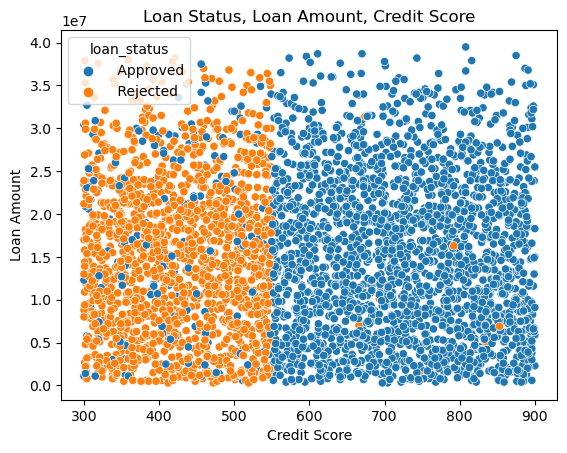

In [7]:
#CrediScore ve LoanAmount arasındaki iliskisi
sns.scatterplot(x=data_full['cibil_score'], y= data_full['loan_amount'], hue=data_full['loan_status'])
plt.title("Loan Status, Loan Amount, Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Loan Amount")
plt.show()

<AxesSubplot:xlabel='loan_status', ylabel='count'>

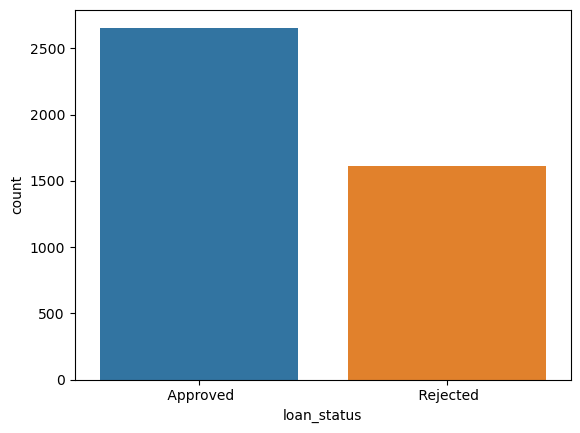

In [8]:
#Histogram loan_status:
sns.countplot(x='loan_status', data=data_full)  

In [9]:
#eksik verilerin doldurulması
#kategorik veriler mode ile dolduruldu
data_full['education'] = data_full['education'].fillna(data_full['education'].mode()[0])
data_full['City'] = data_full['City'].fillna('Others')

#numerik veriler mean ile dolduruldu
data_full['no_of_dependents'] = data_full['no_of_dependents'].fillna(data_full['no_of_dependents'].mean())
data_full['cibil_score'] = data_full['cibil_score'].fillna(data_full['cibil_score'].mean())
data_full['residential_assets_value'] = data_full['residential_assets_value'].fillna(data_full['residential_assets_value'].mean())

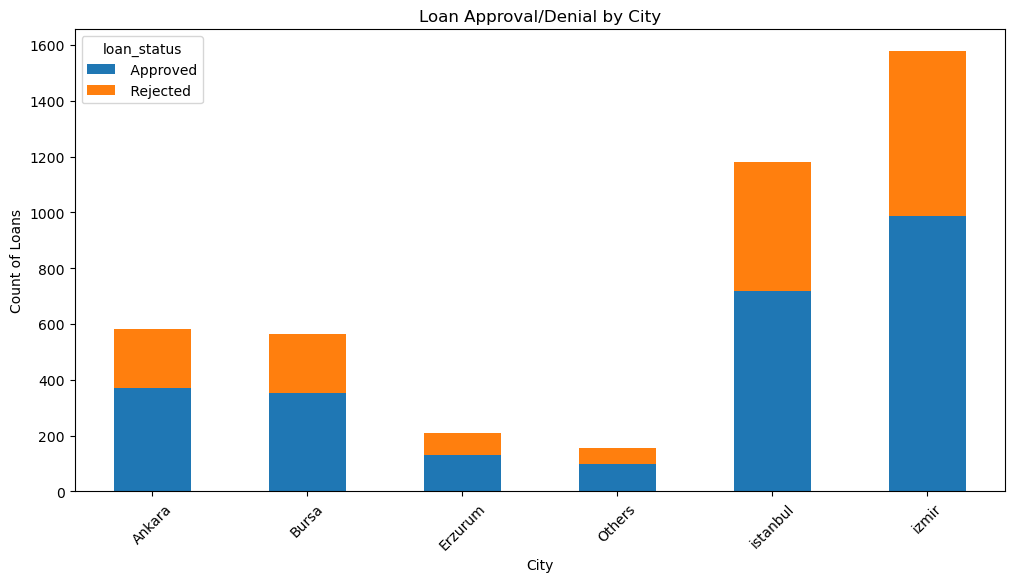

In [10]:
#şehirlere göre kredinin onay/red durumu
city_loan_status = data_full.groupby(['City', 'loan_status']).size().unstack().fillna(0)

# Plot the results
city_loan_status.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Loan Approval/Denial by City')
plt.ylabel('Count of Loans')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.show()

________________________________________________________________________________________

- Veri Kümesindeki Satır ve Sütun Sayısı:

Bu veri kümesi toplam 4269 satır ve 13 sütun içerir. 

- Kredi Durumu (loan_status):
Veri kümesinde 2656 adet “onaylanmış” kredi bulunurken, 1613 adet “reddedilmiş” kredi bulunmaktadır. Onaylanan krediler veri kümesinin %62.2’sini oluşturur.
Bu oran, veri kümesinin hafifçe dengesiz olduğunu gösterse de, kabul edilebilir bir dağılıma sahip olduğu için veri yeniden dengeleme işlemi gerekli görülmemektedir.


Veri kümesinde eksik satırlar City, education, cibil_score, residential_assets_value değişkenlerinde bulunaktadır.
Veride duplicate kayıt bulunmamaktadır.

- Kategorik Sütunlar:

no_of_dependents, education, self_employed ve loan_status sütunları kategorik olarak tanımlanmıştır.


# Data Preprocessing and Feature Engineering

In [11]:
df = data_full.drop(['loan_id'], axis = 1)

In [12]:
#Onehot Encoding
df = pd.get_dummies(df, columns=['City'])

In [13]:
# Label Encoding 
label_encoder = LabelEncoder()
df['self_employed'] = label_encoder.fit_transform(df['self_employed'])
df['loan_status'] = label_encoder.fit_transform(df['loan_status'])
df['education'] = df['education'].apply(lambda x: 1 if x == 'Graduate' else 0)

In [14]:
df.tail()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,City_Ankara,City_Bursa,City_Erzurum,City_Others,City_istanbul,City_izmir
4264,5,1,1,1000000,2300000,12,317.0,2800000.0,500000,3300000,800000,1,0,0,0,0,0,1
4265,0,0,1,3300000,11300000,20,559.0,4200000.0,2900000,11000000,1900000,0,0,0,0,0,0,1
4266,2,0,0,6500000,23900000,18,457.0,1200000.0,12400000,18100000,7300000,1,0,0,0,0,0,1
4267,1,0,0,4100000,12800000,8,780.0,8200000.0,700000,14100000,5800000,0,0,0,0,0,0,1
4268,1,1,0,9200000,29700000,10,607.0,17800000.0,11800000,35700000,12000000,0,0,0,0,0,0,1


In [15]:
#Yeni özellikler
df['income_loan_ratio'] = df['income_annum'] / df['loan_amount']
df['total_assets_perc'] = df['loan_amount'] *100 / df[['residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']].sum(axis=1)

In [16]:
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,City_Ankara,City_Bursa,City_Erzurum,City_Others,City_istanbul,City_izmir,income_loan_ratio,total_assets_perc
0,2,1,0,9600000,29900000,12,778.000000,2400000.0,17600000,22700000,8000000,0,1,0,0,0,0,0,0.321070,58.974359
1,0,0,1,4100000,12200000,8,417.000000,2700000.0,2200000,8800000,3300000,1,1,0,0,0,0,0,0.336066,71.764706
2,3,1,0,9100000,29700000,20,598.538996,7100000.0,4500000,33300000,12800000,1,1,0,0,0,0,0,0.306397,51.473137
3,3,1,0,8200000,30700000,8,598.538996,18200000.0,3300000,23300000,7900000,1,1,0,0,0,0,0,0.267101,58.254269
4,5,0,1,9800000,24200000,20,598.538996,12400000.0,8200000,29400000,5000000,1,1,0,0,0,0,0,0.404959,44.000000


<AxesSubplot:>

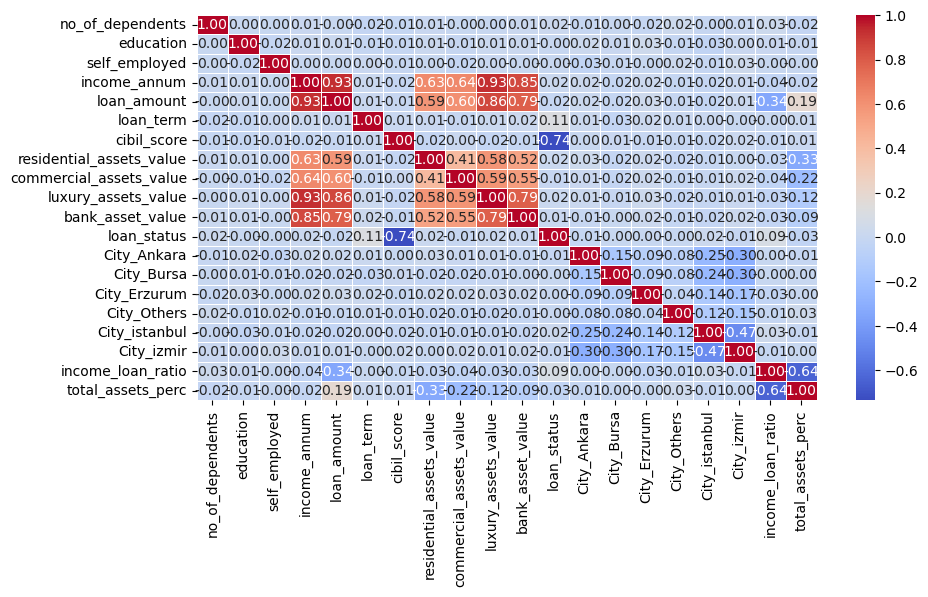

In [17]:
#Korelasyon Matrisi
correlation_matrix = df.corr()
plt.figure(figsize=(10,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

In [18]:
# %90 ve üzeri korelasyona sahip sütunları belirleme ve kaldırma
to_drop = [column for column in correlation_matrix.columns if any((correlation_matrix[column] > 0.9) & (correlation_matrix[column] < 1.0))]
df_last = df.drop(columns=to_drop)
df_last.columns

Index(['no_of_dependents', 'education', 'self_employed', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'bank_asset_value', 'loan_status', 'City_Ankara', 'City_Bursa', 'City_Erzurum', 'City_Others', 'City_istanbul', 'City_izmir', 'income_loan_ratio', 'total_assets_perc'], dtype='object')

In [19]:
# Normalizasyon ve standartlastırma
normalize_columns = ['cibil_score', 'residential_assets_value',	'commercial_assets_value', 'bank_asset_value', 'total_assets_perc']

scaler = MinMaxScaler()
df_last[normalize_columns] = scaler.fit_transform(df_last[normalize_columns])

In [20]:
df_last.head()

,no_of_dependents,education,self_employed,loan_term,cibil_score,residential_assets_value,commercial_assets_value,bank_asset_value,loan_status,City_Ankara,City_Bursa,City_Erzurum,City_Others,City_istanbul,City_izmir,income_loan_ratio,total_assets_perc
0,2,1,0,12,0.796667,0.085616,0.907216,0.544218,0,1,0,0,0,0,0,0.321070,0.422367
1,0,0,1,8,0.195000,0.095890,0.113402,0.224490,1,1,0,0,0,0,0,0.336066,0.521724
2,3,1,0,20,0.497565,0.246575,0.231959,0.870748,1,1,0,0,0,0,0,0.306397,0.364096
3,3,1,0,8,0.497565,0.626712,0.170103,0.537415,1,1,0,0,0,0,0,0.267101,0.416773
4,5,0,1,20,0.497565,0.428082,0.422680,0.340136,1,1,0,0,0,0,0,0.404959,0.306044


# Model Training

In [21]:
#target deegisken
X = df_last.drop('loan_status', axis=1)  
y = df_last['loan_status']

In [30]:
X

,no_of_dependents,education,self_employed,loan_term,cibil_score,residential_assets_value,commercial_assets_value,bank_asset_value,City_Ankara,City_Bursa,City_Erzurum,City_Others,City_istanbul,City_izmir,income_loan_ratio,total_assets_perc
0,2,1,0,12,0.796667,0.085616,0.907216,0.544218,1,0,0,0,0,0,0.321070,0.422367
1,0,0,1,8,0.195000,0.095890,0.113402,0.224490,1,0,0,0,0,0,0.336066,0.521724
2,3,1,0,20,0.497565,0.246575,0.231959,0.870748,1,0,0,0,0,0,0.306397,0.364096
3,3,1,0,8,0.497565,0.626712,0.170103,0.537415,1,0,0,0,0,0,0.267101,0.416773
4,5,0,1,20,0.497565,0.428082,0.422680,0.340136,1,0,0,0,0,0,0.404959,0.306044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,5,1,1,12,0.028333,0.099315,0.025773,0.054422,0,0,0,0,0,1,0.434783,0.205687
4265,0,0,1,20,0.431667,0.147260,0.149485,0.129252,0,0,0,0,0,1,0.292035,0.403146
4266,2,0,0,18,0.261667,0.044521,0.639175,0.496599,0,0,0,0,0,1,0.271967,0.440293
4267,1,0,0,8,0.800000,0.284247,0.036082,0.394558,0,0,0,0,0,1,0.320312,0.309496


In [22]:
# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
#Classification Modelleri
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
svm = SVC(kernel='poly', probability=True)

In [24]:
# Model Eğitimi ve Performans
models = [log_reg, rf, xgb, svm]
model_performance = {} 

print("Model Performansları:\n")
for model in models:
    # Modeli eğitme
    model.fit(X_train, y_train)
    # Tahmin yapma
    y_pred = model.predict(X_test)
    # Performans değerlendirmesi
    accuracy = accuracy_score(y_test, y_pred)
    model_performance[model.__class__.__name__] = accuracy
    print(f"{model.__class__.__name__} Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))

Model Performansları:

LogisticRegression Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       536
           1       0.87      0.83      0.85       318

    accuracy                           0.89       854
   macro avg       0.89      0.88      0.88       854
weighted avg       0.89      0.89      0.89       854

RandomForestClassifier Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       536
           1       1.00      0.92      0.96       318

    accuracy                           0.97       854
   macro avg       0.98      0.96      0.97       854
weighted avg       0.97      0.97      0.97       854

XGBClassifier Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       536
           1       0.96      0.93      0.94       318

    accuracy                           0.96       854
   m

In [25]:
# En iyi performans gösteren modelin seçimi
best_model_name = max(model_performance, key=model_performance.get)
print(f"\nEn iyi performansa sahip model: {best_model_name}")


En iyi performansa sahip model: RandomForestClassifier


In [26]:
if best_model_name == 'RandomForestClassifier':
    rf.fit(X_train, y_train)
    
    # Prediction:
    y_pred = rf.predict(X_test)
    
    # Performans değerlendirmesi
    print("RandomForestClassifier Performans:\n")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

RandomForestClassifier Performans:

Accuracy: 0.968384074941452
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       536
           1       1.00      0.92      0.96       318

    accuracy                           0.97       854
   macro avg       0.98      0.96      0.97       854
weighted avg       0.97      0.97      0.97       854



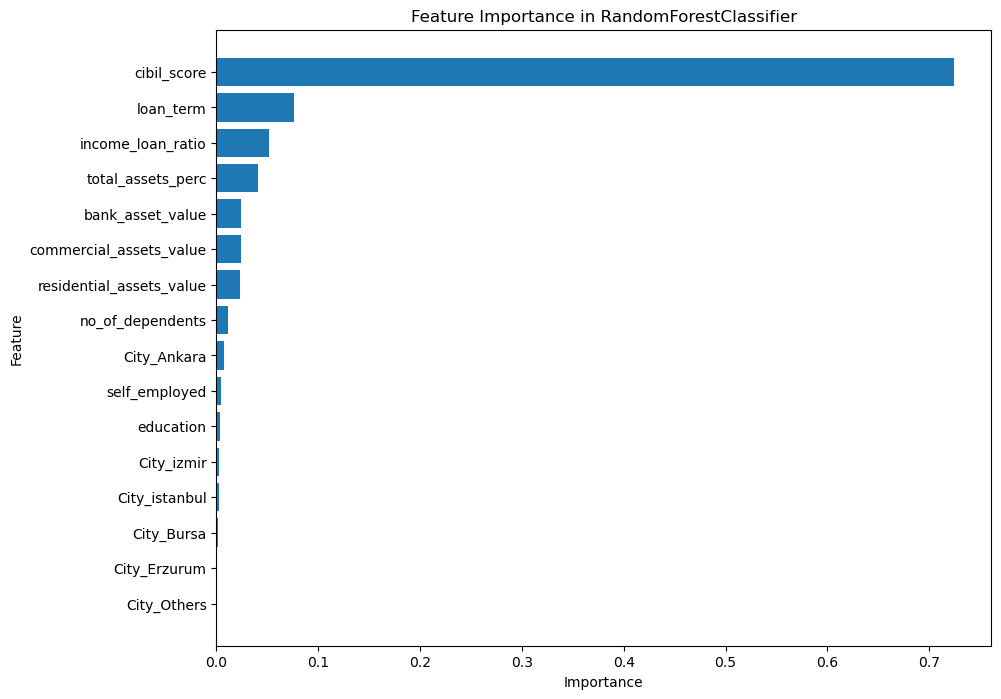

In [27]:
# Feature Importance Analizi
feature_importances = rf.feature_importances_
features = X.columns

#Feature Importance DF
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

# Feature importance grafiği
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in RandomForestClassifier')
plt.gca().invert_yaxis()
plt.show()

In [28]:
# Gerçek ve tahmin edilen değerlerin karşılaştırılması
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
print(predictions_df.head(10))

      Actual  Predicted
1703       1          1
1173       0          0
308        1          1
1322       0          0
3271       0          0
3539       0          0
1522       0          0
3399       1          1
1402       0          0
1829       1          1


In [29]:
joblib.dump(rf, 'final_model.joblib')

['loan_approval_api/final_model.joblib']